In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

In [2]:
print("We're using TF", tf.__version__)

def load_dataset():

    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    return X_train, y_train, X_val, y_val


class DataGen(tf.keras.utils.Sequence):
    def __init__(self, cond):
        self.cond = cond
        self.X_train, self.y_train, self.X_val, self.y_val = load_dataset()
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.cond:
            randomize = np.arange(len(self.X_train))
            np.random.shuffle(randomize)
            self.X_train = self.X_train[randomize]
            self.y_train = self.y_train[randomize]
        else:
            randomize = np.arange(len(self.X_val))
            np.random.shuffle(randomize)
            self.X_val = self.X_val[randomize]
            self.y_val = self.y_val[randomize]

    def __getitem__(self, item):
        if self.cond:
            return np.expand_dims(self.X_train[item], axis=0), np.array([self.y_train[item]])
        else:
            return np.expand_dims(self.X_val[item], axis=0), np.array([self.y_val[item]])

    def __len__(self):
        if self.cond:
            return len(self.X_train)
        else:
            return len(self.X_val)


class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        self.flat = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense2 = tf.keras.layers.Dense(512, activation='relu')
        self.dense3 = tf.keras.layers.Dense(128, activation='relu')
        self.dense4 = tf.keras.layers.Dense(64, activation='relu')
        self.dense5 = tf.keras.layers.Dense(10, activation='softmax')
        # self.batch1 = tf.keras.layers.BatchNormalization() # разобрать, как работает

    def call(self, src):

        output = self.dense1(src)
        output = self.dense2(output)
        output = self.dense3(output)
        output = self.dense4(output)

        output = self.flat(output)

        output = self.dense5(output)

        return output

    def build_graph(self):
        self.build((1, 28, 28))
        inputs = tf.keras.Input(shape=[28, 28])
        self.call(inputs)


model = Model()
model.build_graph()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

train_data = DataGen(True)
val_data = DataGen(False)

model.load_weights("saved_network.hdf5")

We're using TF 2.8.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 28, 1024)          29696     
                                                                 
 dense_1 (Dense)             (None, 28, 512)           524800    
                                                                 
 dense_2 (Dense)             (None, 28, 128)           65664     
                                                                 
 dense_3 (Dense)             (None, 28, 64)            8256      
                                                                 
 dense_4 (Dense)             (None, 10)                17930     
                                                                 
Total params: 646,346
Trainable params: 

8 8


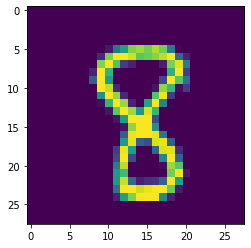

In [7]:
X_train, y_train, X_val, y_val = load_dataset()

num = 1

prediction = model(np.expand_dims(X_val[num], axis=0))
true = y_val[num]
print(np.argmax(prediction), true)

plt.clf()
plt.imshow(X_val[num])
plt.show()